# Convolutional Neural Networks

# Train model for classifying cifar-10 database.

It falls into 10 classes.

In [35]:
import torch
import numpy       as np
from   torchvision import datasets
import torchvision.transforms as transforms
from   torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# Load and Augment the Data

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

#### Augmentation

In this cell, we perform some simple data augmentation by randomly flipping and rotating the given image data. We do this by defining a torchvision transform, and you can learn about all the transforms that are used to pre-process and augment data, here.

In [27]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size  = 20
# percentage of training set to use as validation
valid_size = 0.2

In [13]:
# convert data to a normalized torch.FloatTensor

In [17]:
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                ])

In [18]:
# Choose the training and test datasets
train_data = datasets.CIFAR10('data',train=True,download=True,transform=transform)

0it [00:00, ?it/s]


0it [00:00, ?it/s]
  0%|          | 16384/170498071 [00:00<18:29, 153725.22it/s]

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to data/cifar-10-python.tar.gz



 99%|█████████▉| 169091072/170498071 [00:10<00:00, 15771552.61it/s]

Extracting data/cifar-10-python.tar.gz to data



170500096it [00:28, 15771552.61it/s]                               

In [19]:
test_data = datasets.CIFAR10('data',train=False,download=True,transform=transform)

Files already downloaded and verified


In [23]:
# obtain training indices that will be used used for validation
num_train = len(train_data)
indices   = list(range(num_train))
np.random.shuffle(indices)

In [28]:
split = int(np.floor(valid_size * num_train))

In [29]:
train_idx, valid_idx = indices[split:], indices[:split]

In [30]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [31]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [33]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize a Batch of Training Data

In [34]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [36]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

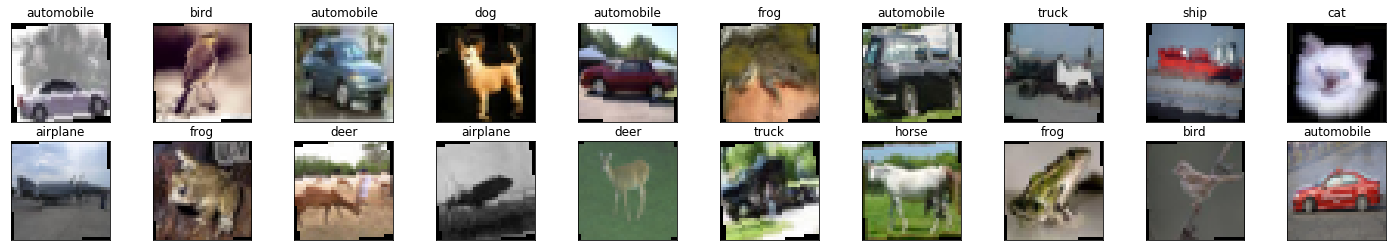

In [41]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

View an Image in More Detail
Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

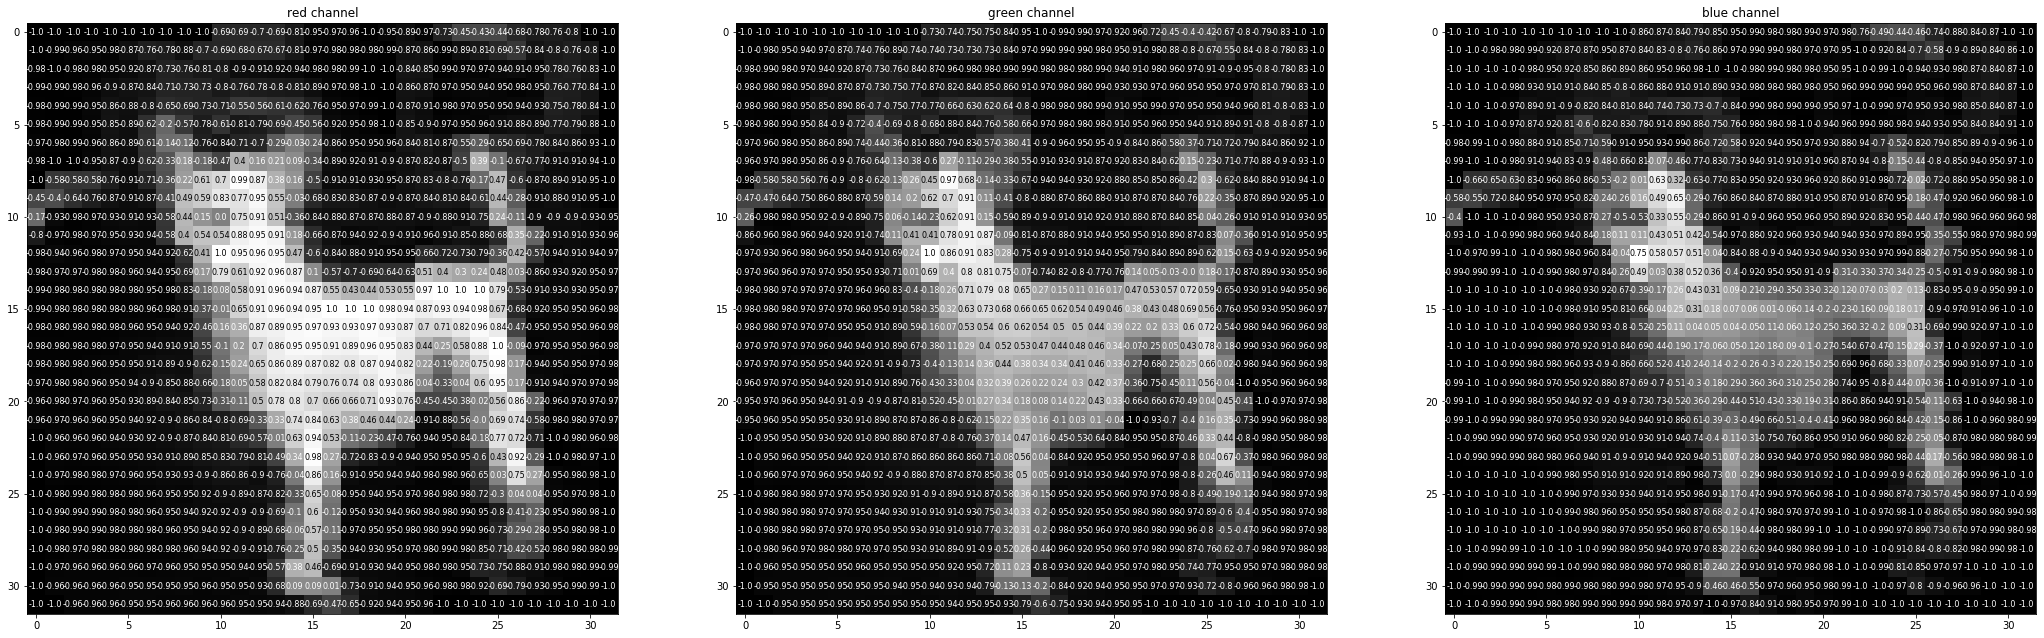

In [42]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

Define the Network Architecture
This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:

Convolutional layers, which can be thought of as stack of filtered images.
Maxpooling layers, which reduce the x-y size of an input, keeping only the most active pixels from the previous layer.
The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.
A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src='notebook_ims/2_layer_conv.png' height=50% width=50% />

TODO: Define a model with multiple convolutional layers, and define the feedforward metwork behavior.
The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting.

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at this PyTorch classification example or this, more complex Keras example to help decide on a final structure.

Output volume for a convolutional layer
To compute the output size of a given convolutional layer we can perform the following calculation (taken from Stanford's cs231n course):

We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by (W−F+2P)/S+1.

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.